In [1]:
pip install pandas matplotlib

Note: you may need to restart the kernel to use updated packages.


In [7]:
import pandas as pd
import matplotlib.pyplot as plt

file_path = "Non smoker.csv"

data = pd.read_csv(file_path)

timestamp_column = data.columns[0]
signal_columns = data.columns[1:]   # All remaining columns are sensor data

In [9]:
#Adjust the Plot for Full Signal Representation
#For the AX3 device, the sampling interval isn’t explicitly provided, we can calculate it using the first two timestamps.

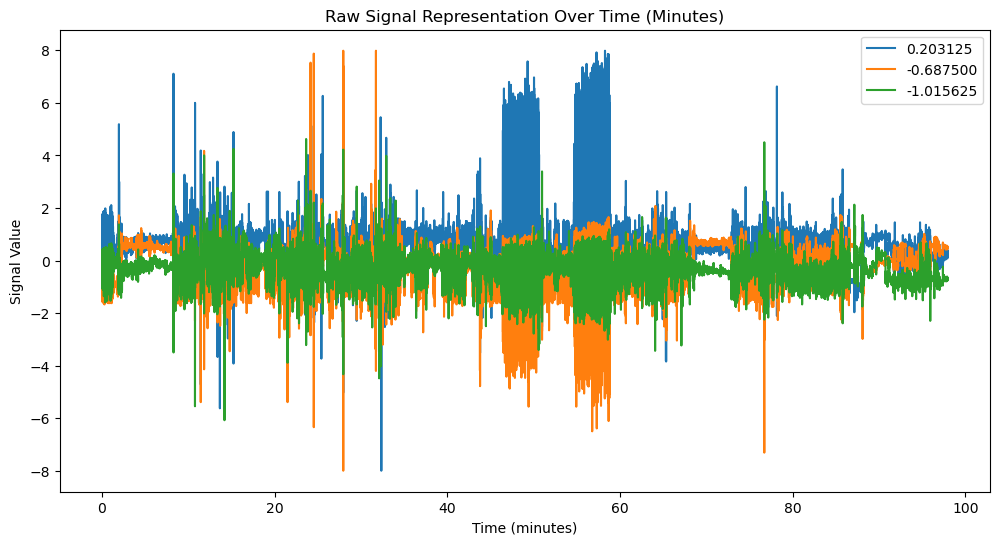

In [11]:
# Calculate the sampling interval (in seconds)
sampling_interval = (pd.to_datetime(data[timestamp_column].iloc[1]) -
                     pd.to_datetime(data[timestamp_column].iloc[0])).total_seconds()

# Create a relative time axis (in minutes)
data['relative_time_minutes'] = data.index * sampling_interval / 60

# Plot the signal with time in minutes
plt.figure(figsize=(12, 6))
for signal in signal_columns:
    plt.plot(data['relative_time_minutes'], data[signal], label=signal)

plt.title("Raw Signal Representation Over Time (Minutes)")
plt.xlabel("Time (minutes)")
plt.ylabel("Signal Value")
plt.legend()
plt.show()

In [15]:
#1. Zoom in on Specific Intervals
#The cardio activity spans a long duration, focusing on shorter time intervals can reveal finer details:

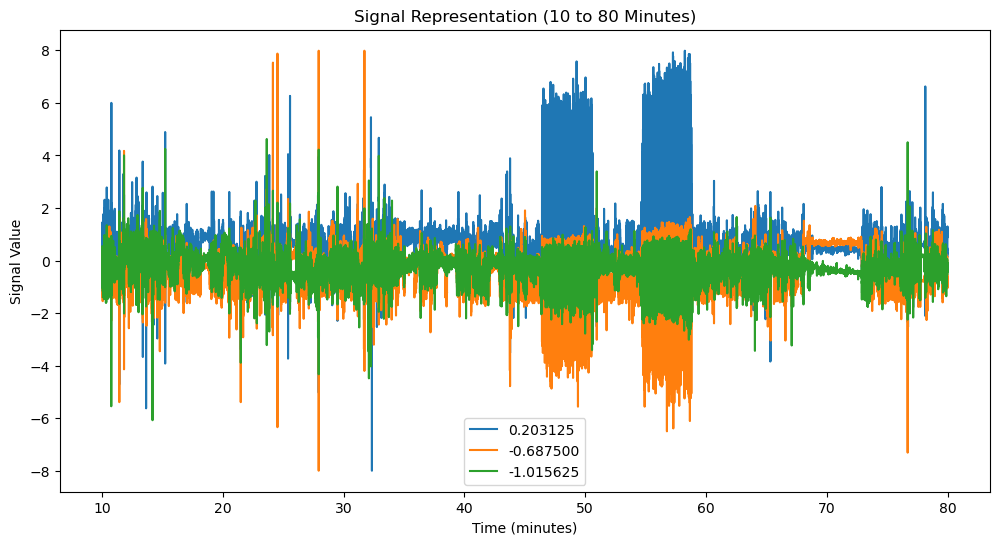

In [17]:
# Filter data to keep only rows where time is between 10 and 80 minutes
filtered_data = data[(data['relative_time_minutes'] >= 10) & (data['relative_time_minutes'] <= 80)]


# Plot the filtered signal
plt.figure(figsize=(12, 6))
for signal in signal_columns:
    plt.plot(filtered_data['relative_time_minutes'], filtered_data[signal], label=signal)

plt.title("Signal Representation (10 to 80 Minutes)")
plt.xlabel("Time (minutes)")
plt.ylabel("Signal Value")
plt.legend()
plt.show()

In [19]:
#2. Apply a Low-Pass Filter

In [21]:
from scipy.signal import butter, filtfilt

# Function to apply a low-pass filter
def lowpass_filter(data, cutoff, fs, order=4):
    """
    Apply a low-pass Butterworth filter.
    
    Parameters:
        data (array-like): The signal to filter.
        cutoff (float): The cutoff frequency in Hz.
        fs (float): The sampling frequency in Hz.
        order (int): The order of the filter (default is 4).
    
    Returns:
        array-like: The filtered signal.
    """
    nyquist = 0.5 * fs  # Nyquist frequency
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, data)

C:\Users\rasha\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


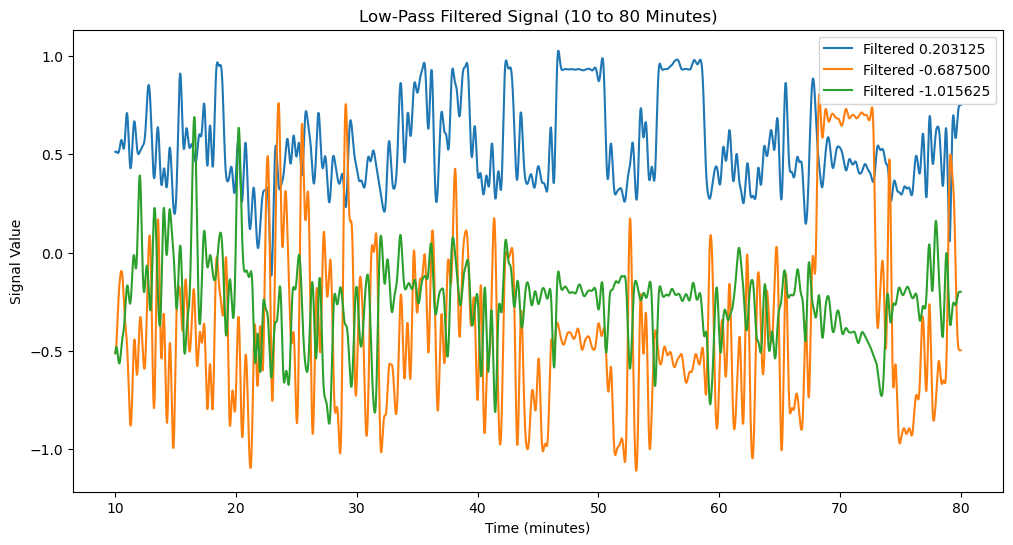

In [23]:
# Define sampling frequency (fs) and cutoff frequency
fs = 1 / (sampling_interval / 60)  # Sampling frequency in Hz (based on time in minutes)
cutoff = 2  # Low-pass filter cutoff frequency in Hz

# Apply the filter to each signal column
filtered_signals = {}
for signal in signal_columns:
    filtered_signals[signal] = lowpass_filter(filtered_data[signal], cutoff, fs)

# Convert filtered signals back to a DataFrame for easy plotting
filtered_data_df = pd.DataFrame(filtered_signals)
filtered_data_df['relative_time_minutes'] = filtered_data['relative_time_minutes'].values

# Plot the low-pass filtered signals
plt.figure(figsize=(12, 6))
for signal in signal_columns:
    plt.plot(filtered_data_df['relative_time_minutes'], filtered_data_df[signal], label=f"Filtered {signal}")

plt.title("Low-Pass Filtered Signal (10 to 80 Minutes)")
plt.xlabel("Time (minutes)")
plt.ylabel("Signal Value")
plt.legend()
plt.show()

In [25]:
#[COM] Utilisation Pratique

Nombre total de pics détectés : 17
Intervalle moyen entre les pics : 4.12 minutes
Cadence moyenne : 0.79 pas par minute


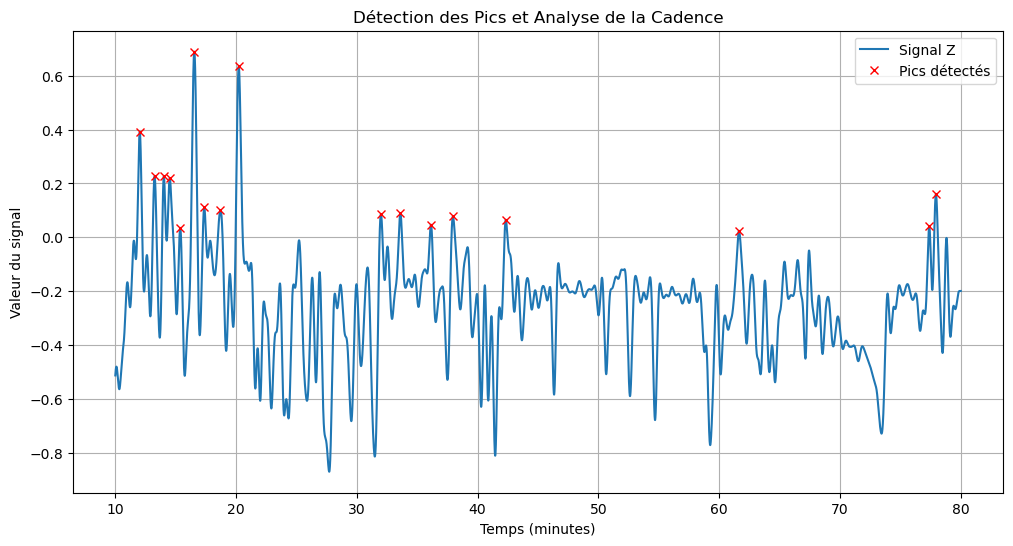

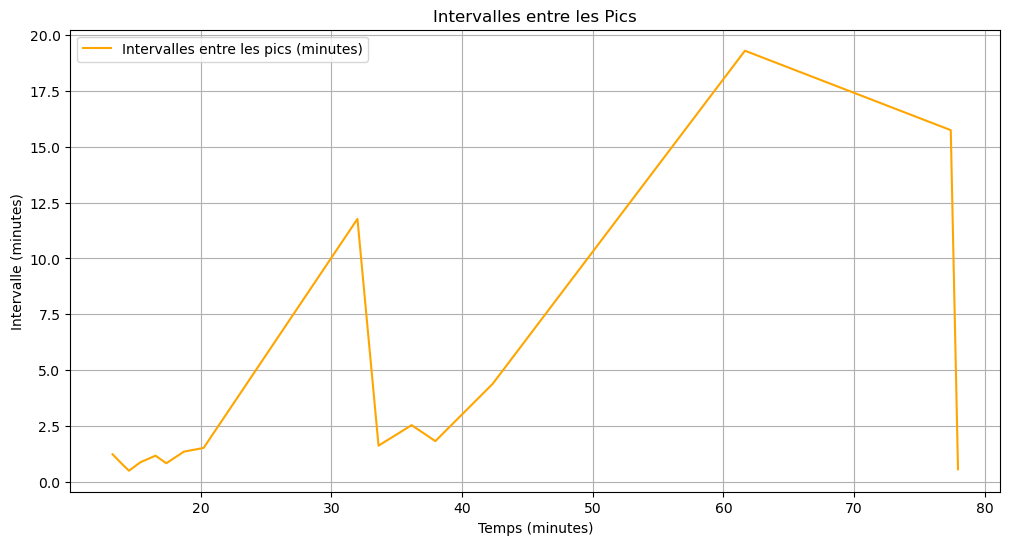

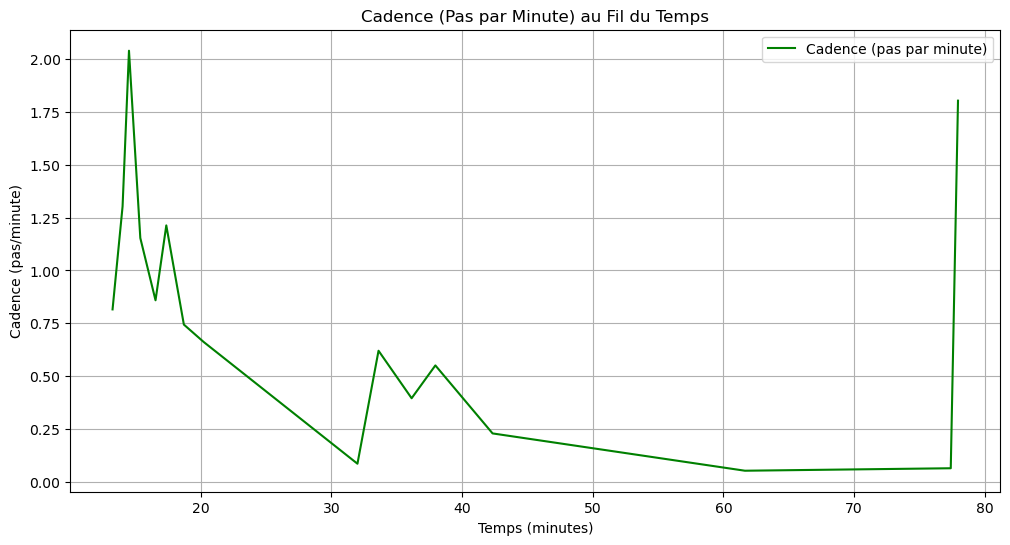

In [27]:
from scipy.signal import find_peaks
import matplotlib.pyplot as plt

# Sélectionnez l'axe pertinent (par exemple, axe Z)
signal_column = signal_columns[2]  # Supposons que l'axe Z est la troisième colonne

# Détectez les pics dans le signal filtré
peaks, _ = find_peaks(filtered_data_df[signal_column], height=0)  # Ajustez 'height' si nécessaire

# Calculez les temps associés aux pics détectés
peak_times = filtered_data_df['relative_time_minutes'].iloc[peaks]

# Calculez les intervalles entre les pics (en minutes)
intervals = peak_times.diff().dropna()

# Convertissez les intervalles en cadence (pas par minute)
cadence = 1 / intervals  # En pas par minute

# Affichez les statistiques
print(f"Nombre total de pics détectés : {len(peaks)}")
print(f"Intervalle moyen entre les pics : {intervals.mean():.2f} minutes")
print(f"Cadence moyenne : {cadence.mean():.2f} pas par minute")

# Visualisez le signal et les pics détectés
plt.figure(figsize=(12, 6))
plt.plot(filtered_data_df['relative_time_minutes'], filtered_data_df[signal_column], label="Signal Z")
plt.plot(peak_times, filtered_data_df[signal_column].iloc[peaks], "x", label="Pics détectés", color='red')
plt.title("Détection des Pics et Analyse de la Cadence")
plt.xlabel("Temps (minutes)")
plt.ylabel("Valeur du signal")
plt.legend()
plt.grid(True)
plt.show()

# Visualisez les intervalles entre les pics
plt.figure(figsize=(12, 6))
plt.plot(peak_times.iloc[1:], intervals, label="Intervalles entre les pics (minutes)", color='orange')
plt.title("Intervalles entre les Pics")
plt.xlabel("Temps (minutes)")
plt.ylabel("Intervalle (minutes)")
plt.legend()
plt.grid(True)
plt.show()

# Visualisez la cadence
plt.figure(figsize=(12, 6))
plt.plot(peak_times.iloc[1:], cadence, label="Cadence (pas par minute)", color='green')
plt.title("Cadence (Pas par Minute) au Fil du Temps")
plt.xlabel("Temps (minutes)")
plt.ylabel("Cadence (pas/minute)")
plt.legend()
plt.grid(True)
plt.show()

In [29]:
#Analyse des Graphiques